<h3>Setup</h3>
Import dependencies, then EITHER load the data file for a given day and process it (assign neurons to nerves randomly) or load a pre-processed set of neurons.

In [286]:
#USER CHANGE THESE VARIABLES
#a set of dates to flip between, for cat 1
#first load the relevant dates for filename
reload_labels = True  # mark true to iterate through elec opts files and write to csv

test_lvl = 'L7'  # loaded so far: all lvls chan 1, 4, 5, 8, 17, 20, 21, 24, 7, 6, 9, 12, 13, 16, 3, 2; L6, L7 - 10; L6 - 11, 18, 19, 14, 23, 22
test_chan = 14
test_cat = 'cat1'

recruit_thresholds = [1, 5, 10, 25, 50, 90] #[1, 5, 10, 50, 90]
recalc_rec = False
rec_range = range(0, 3001, 5) #recruitment range to calculate and save
show_max = 1000 #what to show in plots

fname_summary = 'summary_rec_loc.csv' #'summary_rec.csv' 


In [287]:
import os
import glob
import pandas as pd


cdir = 'P:/users/mkj8/sc_modeling/sim4life'
fpath = os.path.join(cdir, 'saved_data_finalmodel')

if reload_labels: #load all elec opts and write to a csv file
    lvls = []
    chans = []
    cats = []
    fdates = []
    fnames_lst = glob.glob(os.path.join(fpath, 'elec_opts*csv'))
    for f in fnames_lst: 
        opts = pd.read_csv(f)
        #pull out spinal level, channel, date, cat
        lvls.append(opts.template_name[0])
        chans.append(opts.contact_number[0])
        cats.append(opts.neuron_set[0])
        fdates.append(f.split('opts')[1][:-4])
    tmp = pd.DataFrame(data={'neuron_set': cats,'spinal_level': lvls, 
                'electrode':chans, 'filedate':fdates})
    tmp.to_csv(os.path.join(fpath, 'all_runs.csv'))

else: 
    tmp = pd.read_csv(os.path.join(fpath, 'all_runs.csv'))

#print(tmp)
fdate = tmp[(tmp['spinal_level'] == test_lvl) &
            (tmp['electrode'] == test_chan) & (tmp['neuron_set'] == test_cat)]['filedate'].to_list()[0]   # '2022-04-27_1426', '2022-05-02_1730' '2022-05-04-1000' '22-04-22_1207'# date the simulation was run, as a string, ie '2022-04-21_1445' - will match a titrate results file in the sim4life/saved_data_finalmodel folder


In [288]:
import seaborn as sns
import plotly.express as px
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

from helper_fn import *
from plotting_fn import *

# import the header CSV file describing settings for the run
cdir = 'P:/users/mkj8/sc_modeling/sim4life'
fname = 'elec_opts' + fdate + '.csv'
optspath = os.path.join(fpath, fname)
opts = pd.read_csv(optspath)
print(opts.columns)

print('Simulation performed at ' + str(opts.template_name[0]) + ' contact ' +
      str(opts.contact_number[0]) + ' at z ' + str(opts.elec_midpt_z[0]))

print('x at: ' + str(opts.elec_midpt_x[0]))


Index(['model_volumes', 'template_name', 'contact_number', 'neuron_set',
       'elec_midpt_x', 'elec_midpt_y', 'elec_midpt_z'],
      dtype='object')
Simulation performed at L7 contact 10 at z 38.137306213378906
x at: 12.157764625549316


In [289]:
#TODO: make a new section here that calculates the pdata, exp_sdist, and act_slst variables but doesn't redistribute the neurons
dname = 'titrate' + fdate + '.csv'
dpath = os.path.join(cdir, 'saved_data_finalmodel', dname)
data = pd.read_csv(dpath)

pd_path = os.path.join(cdir, 'processed_data',
                     str(opts.template_name[0]))
inc_reclocs = ['graymatter', 'whitematter', 'dorsalroots', 'ventralroots']

pdata = data[data['enc_tissue'].isin(inc_reclocs)].copy()
#label with electrode number for saving
#how different is this pdata variable? should I resave it?
#add labels based on name of each neuron
spinal_lvl_idx = np.empty(len(pdata), dtype='<U2')

rnames = ['L6', 'L7', 'S1', 'S2', 'S3']
for i in range(len(rnames)):
    spinal_lvl_idx[pdata['name'].str.contains(rnames[i])] = rnames[i]

pdata['root'] = spinal_lvl_idx
pdata['type'] = [['afferent', 'efferent'][i]
                for i in pdata['name'].str.lower().str.contains('ventral')*1]
pdata['side'] = [['right', 'left'][i]
                for i in pdata['name'].str.lower().str.contains('left')*1]

#now, scale all of this by number of neurons per root

print(pdata.columns)



Index(['name', 'nerve', 'diameter', 'elec_dist', 'enc_tissue', 'rec_amp',
       'act_midpt_x', 'act_midpt_y', 'act_midpt_z', 'closest_x', 'closest_y',
       'closest_z', 'root', 'type', 'side'],
      dtype='object')


<h3>Calculate/load recruitment</h3>
Calculate recruitment across a large range of amplitudes (roots, nerves, etc.)

In [290]:
#AT THIS point, calculate the percent recruitment of each category
#Then scale all the subcategories (dorsal/ventral, root, nerve)
#no need to scale left/right

#RECRUITMENT: rows are amps, columns are labels + percent rec: rec of subgroup such that adding the subgroups
#results in full percent recruitment of, say, a nerve, or all S1 recruitment

#determine name of file to save to
#if the file exists already and recalc_rec is false, load from file
pname = 'scale_rec_ch' + str(opts.contact_number[0]) + '_' + fdate + '.csv'
ppath = os.path.join(pd_path, pname)

lnames = ['L6', 'L7', 'S1']
nnames = ['Pelvic', 'Pudendal', 'Sciatic'] #must match the order of the dist_arr later
v_rel = {'L6': [0, 0, 0.0339], 'L7': [0, 0, 0.0587], 'S1': [x*0.0753/100 for x in [7, 62, 31]],
         'S2': [x*0.0433/100 for x in [66, 29, 5]], 'S3': [x*0.0286/100 for x in [13, 87, 0]]}
d_rel = {'L6': [0, 0, 0.1602], 'L7': [0, 0, 0.2795], 'S1': [x*0.1610/100 for x in [9, 22, 69]],
         'S2': [x*0.1284/100 for x in [55, 37, 8]], 'S3': [x*0.0312/100 for x in [64, 36, 0]]}
#these proportions are set up such that the sum of all recruitment across everything = 1.0
if not os.path.exists(ppath): 
    recalc_rec = True

if recalc_rec:
    print('Calculate and save recruitment')
    full_rec = pd.DataFrame(data={'amp': np.sort(list(rec_range)*len(rnames)*len(nnames)*2*2), 
                                'root': list(np.sort(list(rnames)*len(nnames)*2*2))*len(rec_range),
                                'nerve': list(np.sort(list(nnames)*2*2))*len(rnames)*len(rec_range),
                                'type': list(np.sort(['afferent', 'efferent']*2))*len(rec_range)*len(nnames)*len(rnames),
                                'side': ['left', 'right']*len(nnames)*len(rec_range)*len(rnames)*2})

    rec = [] #raw recruitment (number of neurons)
    prop = [] #percent recruitment (scaled by level)

    for i in range(len(full_rec)):
        rec.append(sum(pdata[(pdata['root'] == full_rec['root'][i]) & 
                    (pdata['nerve'] == full_rec['nerve'][i]) &
                    (pdata['type'] == full_rec['type'][i]) &
                    (pdata['side'] == full_rec['side'][i])]
                    ['rec_amp'] < full_rec['amp'][i]))
        #This calculates proportion of the neurons present, but does not scale
        if rec[-1]>0:
            prop.append(rec[-1]/len(pdata[(pdata['root'] == full_rec['root'][i]) &
                        (pdata['nerve'] == full_rec['nerve'][i]) &
                        (pdata['type'] == full_rec['type'][i]) &
                        (pdata['side'] == full_rec['side'][i])]))
        else: 
            prop.append(0)
        
    full_rec['rec_amps'] = rec
    full_rec['rec_prop'] = prop


    #SCALING
    #now, scale all of this by number of neurons per root
    #NEURON DISTRIBUTIONS (revised March 2022 - info in Model Neuron distributions ppt and model_distributions.m)
    #NEURON DISTRIBUTIONS FOR BLIND DIST - relevant neurons per level (sums to 1)


    full_rec['scale_rec'] = prop

    for aff in range(2):
        if aff:
            dist_arr = d_rel
            tmp = full_rec[full_rec['type'] == 'afferent']
        else:
            dist_arr = v_rel
            tmp = full_rec[full_rec['type'] == 'efferent']
        for r in rnames:
            #load the data for that root, then that nerve
            for n in range(len(nnames)):
                #with loaded data, find all the relevant examples, then scale (left and right scale the same way so divide by 2)
                scaled = tmp[(tmp['nerve'] == nnames[n]) & (tmp['root'] == r)
                    ]['rec_prop']*dist_arr[r][n]*100/2
                full_rec.loc[(full_rec['type'] == ['efferent','afferent'][aff]) & 
                    (full_rec['nerve'] == nnames[n]) &
                    (full_rec['root'] == r), ['scale_rec']] = scaled

    full_rec.to_csv(ppath)
    print('Saved in ' + ppath)

else: 
    print('Loading previously calculated values')
    full_rec = pd.read_csv(ppath)


Calculate and save recruitment
Saved in P:/users/mkj8/sc_modeling/sim4life\processed_data\L7\scale_rec_ch10_2022-09-19_0823.csv


<h3>Recruitment curves</h3>
Recruitment curves for all neurons and subsets of the neuron population (roots, nerves, etc.)

In [291]:
#Calculate recruitment curves for each nerve + aff/eff

#if we ignore root level and add the nerve counts up...
df_sum = pd.DataFrame(data={'amp': np.sort(
    list(rec_range)*len(nnames)), 'nerve': nnames*len(rec_range)})

#make dictionary of total scaling factors to get each nerve to 100%
adict = {nnames[0]: sum([x[0] for x in d_rel.values()]),
         nnames[1]: sum([x[1] for x in d_rel.values()]),
         nnames[2]: sum([x[2] for x in d_rel.values()])}
edict = {nnames[0]: sum([x[0] for x in v_rel.values()]),
         nnames[1]: sum([x[1] for x in v_rel.values()]),
         nnames[2]: sum([x[2] for x in v_rel.values()])}

a_rec = []
a_prop = []
e_rec = []
e_prop = []
for i in range(len(df_sum)):
    a_rec.append(sum(full_rec[(full_rec['amp'] == df_sum['amp'][i]) & (
        full_rec['nerve'] == df_sum['nerve'][i]) & 
        (full_rec['type'] == 'afferent')]['scale_rec']))
    e_rec.append(sum(full_rec[(full_rec['amp'] == df_sum['amp'][i]) & (
        full_rec['nerve'] == df_sum['nerve'][i]) &
        (full_rec['type'] == 'efferent')]['scale_rec']))
    a_prop.append(a_rec[-1]/adict[df_sum['nerve'][i]])
    e_prop.append(e_rec[-1]/edict[df_sum['nerve'][i]])

df_sum['aff_ct'] = a_rec
df_sum['eff_ct'] = e_rec
df_sum['aff_prop'] = a_prop
df_sum['eff_prop'] = e_prop


In [292]:
#save these recruitment curves to file: format: .txt file, list of amps, then lists of each relevant piece
wlst = []
wlst.append('Amps ' + ','.join([str(x) for x in df_sum['amp'].unique()]))

plst = df_sum[df_sum['nerve'] == 'pelvic']['aff_prop']
wlst.append('PelvicAff ' + ','.join([str(round(x, 5))
            for x in df_sum[df_sum['nerve'] == 'pelvic']['aff_prop']]))
wlst.append('PelvicEff ' + ','.join([str(round(x, 5))
            for x in df_sum[df_sum['nerve'] == 'pelvic']['eff_prop']]))
wlst.append('PudendalAff ' + ','.join([str(round(x, 5))
            for x in df_sum[df_sum['nerve'] == 'pudendal']['aff_prop']]))
wlst.append('SciaticAff ' + ','.join([str(round(x, 5))
            for x in df_sum[df_sum['nerve'] == 'sciatic']['aff_prop']]))

with open(os.path.join(cdir, 'saved_data_finalmodel', 'rec_task3_{}.txt'.format(fdate)), 'w') as file:
    file.write('\n'.join(wlst))

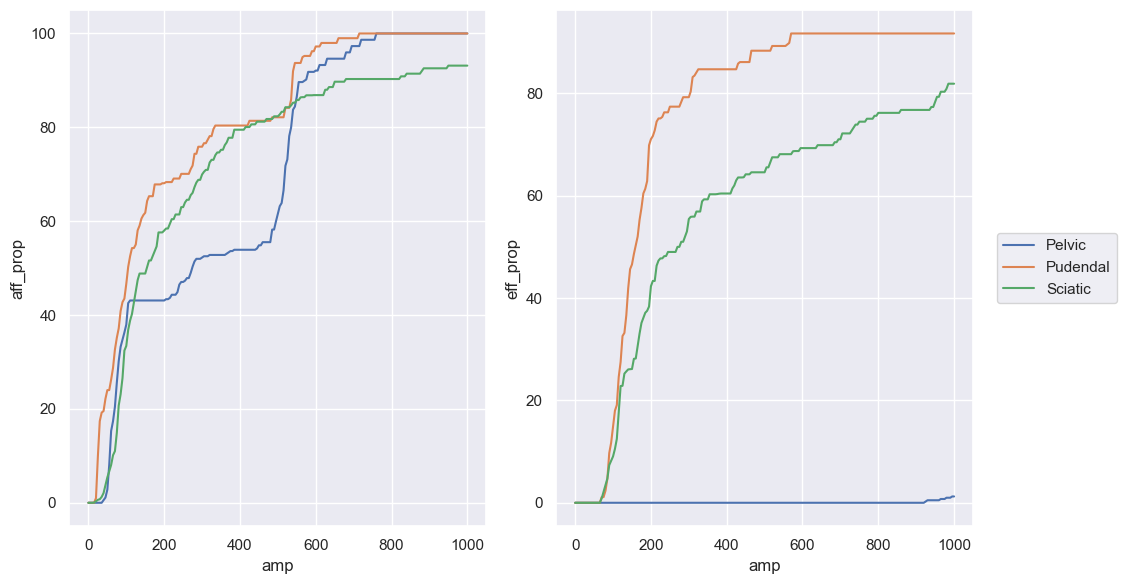

In [293]:
#plot the curves 

sns.set_theme('notebook')
sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots(1, 2)
f1 = sns.lineplot(ax=ax[0], data=df_sum[df_sum['amp'] <= show_max], x='amp', y='aff_prop', hue='nerve')
f2 = sns.lineplot(ax=ax[1], data=df_sum[df_sum['amp'] <= show_max], x='amp', y='eff_prop', hue='nerve')
fig.tight_layout()
l = f1.get_legend()
l.remove()
l = f2.get_legend()
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')


## Save Summary Data

In [294]:
#add to an existing spreadsheet
#columns: electrode, level, threshold percent, type, pelvic, pudendal, sciatic (in each nerve column do recruitment amplitude)
summary_path = os.path.join(fpath, fname_summary)

#load previous version
try:
    full_summary = pd.read_csv(summary_path)
    #check that it's not duplicating a previous input: if so, break and print error
    if len(full_summary[(full_summary['spinal_level'] == opts.template_name[0]) & (full_summary['electrode'] == opts.contact_number[0]) & (full_summary['neuron_set'] == opts.neuron_set[0])])>1:
        raise Exception('Have previously saved recruitment from this simulation')
except: 
    print('Saving new file')
#for several threshold levels, and both aff and eff, calculate recruitment
pelrec = []
pudrec = []
scirec = []
typelist = []

for ty in ['afferent', 'efferent']:
    if ty == 'afferent':
        fieldname = 'aff_prop'
    else:
        fieldname = 'eff_prop'
    for thresh_percent in recruit_thresholds:
        #calculate recruitment amplitude of each nerve type
        try:
            pelrec.append(df_sum.iloc[df_sum[(df_sum[fieldname] >= thresh_percent) & (
                df_sum['nerve'] == 'Pelvic')].index[0]]['amp'])
        except:
            print('Skipping a row for pelvic nerve')
            pelrec.append(float('nan'))
        try:
            pudrec.append(df_sum.iloc[df_sum[(df_sum[fieldname] >= thresh_percent) & (
                df_sum['nerve'] == 'Pudendal')].index[0]]['amp'])
        except:
            print('Skipping a row for pudendal nerve')
            pudrec.append(float('nan'))
        try:
            scirec.append(df_sum.iloc[df_sum[(df_sum[fieldname] >= thresh_percent) & (
                df_sum['nerve'] == 'Sciatic')].index[0]]['amp'])        
        except:
            print('Skipping a row for sciatic nerve')
            scirec.append(float('nan'))
        typelist.append(ty)

#build this and then write all at the same time
summary_df = pd.DataFrame(data={'neuron_set': [opts.neuron_set[0]]*len(recruit_thresholds)*2,
            'spinal_level': [opts.template_name[0]]*len(recruit_thresholds)*2, 
            'electrode': [opts.contact_number[0]]*len(recruit_thresholds)*2, 
            'rec_threshold': recruit_thresholds*2, 
            'type': typelist, 
            'pelvic': pelrec, 'pudendal': pudrec, 'sciatic': scirec})

#add the row, column
row_num = []  # row of the array (1-3 L6, 4-6 L7, 7-9 S1)
col_num = []
#layout of the electrode array
elec_layout = [[8, 7, 6, 5, 4, 3, 2, 1],
               [16, 15, 14, 13, 12, 11, 10, 9], [24, 23, 22, 21, 20, 19, 18, 17]]
#just add the row and column info to the summary rec thing
for i in range(len(summary_df['electrode'])):
    index = [j for j, x in enumerate(
        elec_layout) if summary_df['electrode'].iloc[i] in x][0]
    row_num.append(index + lnames.index(summary_df['spinal_level'].iloc[i])*3)
    col_num.append(elec_layout[index].index(
        summary_df['electrode'].iloc[i]))

summary_df['row'] = row_num
summary_df['col'] = col_num


In [295]:
#only save if it hasn't been saved previously/is being recalculated
if recalc_rec:
    summary_df.to_csv(summary_path, mode='a', header=not os.path.exists(summary_path))
else: 
    print('Not saving any new data')
    #raise Exception('Not saving any new data')

<h3>Tissue/location of first recruited segment</h3>
especially focus here on dorsal columns (white matter) vs dorsal roots

[Text(0.5, 1.0, 'L7 channel 10')]

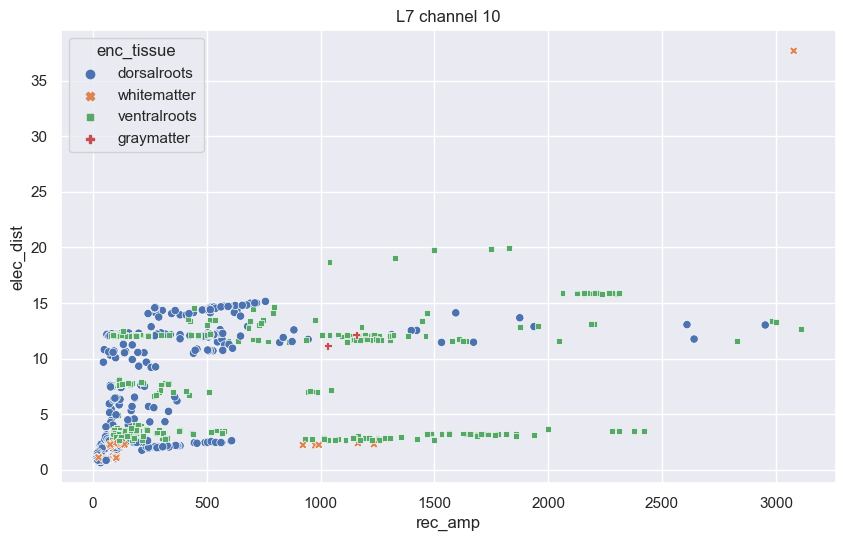

In [296]:
#Distribution vs amplitude plot, which neurons are recruited as dots
from turtle import title


sns.set(rc={'figure.dpi': 100})
sns.scatterplot(data=pdata[pdata['rec_amp']<4000], x='rec_amp', y='elec_dist', hue='enc_tissue', style='enc_tissue').set(title=test_lvl + ' channel ' + str(test_chan))

#Reverse: for 1 axon, distance (to electrode) vs amplitude


In [297]:
#TODO add first recruited tissue, location
#HOW TO DO AS SUMMARY NOT AS INDIV NEURON??? I think just calculate it as first recruitment at same thresholds as the pelvic, pudendal, sciatic labels
#what about within category though
#damn
#OKAY make this a totally new dataframe
#for each tissue type, calculate the overall and split by nerve threshold amplitude 
#also split by ventral/dorsal, root lvl, root laterality
#also somehow show activation hotspots? I don't know how to do this in a summary format
#do this by adding it to typelist! so that's afferent, efferent and then tissue body


<h3>Threshold scatter plots</h3>
Plot overall threshold to recruit afferents vs efferents. Plot the recruitment amplitude against the electrode distance, separated by root and with marginal distributions of the sizes.

In [298]:
#TO ADD: 
#focality of stimulation plots
#separate the following distance from electrode plots by tissue type
#draw the cord on for clear visual
#make recruitment curves but for afferents only and recruited in wm (dorsal column) vs roots
#make some kind of xy heat map slices (near electrode, I guess?)

<h3>Messing around</h3>
Ternary plots, heat maps, and so on